## ILB

In [15]:
import numpy as np
import random #pseudorandom
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import distance
import math
import pandas as pd

In [16]:
import seaborn as sns
import pandas as pd

###Functions

In [36]:
def load_data(filename, x_col, y_col, z_col):
    # Load File with x,y,z points extracted from stl files

    # Get column header for each axis
    x_column = 'Points:'+ str(x_col)
    y_column = 'Points:'+ str(y_col)
    z_column = 'Points:'+ str(z_col)
    # Read file
    df = pd.read_csv(filename,header=0,sep=',')
    # Export to numpy array
    x = df[x_column].to_numpy()
    y = df[y_column].to_numpy()
    z = df[z_column].to_numpy()

    return x,y,z

In [19]:
def calculate_z(x, y, z, x_query, y_query):
    # Find z for each pair of x,y
    points = np.column_stack((x, y))
    values = z
    z_query = griddata(points, values, (x_query, y_query), method='nearest')
    return z_query

In [20]:
def calculate_distance(Zup, Zdown):
    # Calculate distance between surface A and B
    distance = np.sqrt((Zup - Zdown) ** 2)
    return distance

In [21]:
def get_x_distance(x, y):
  # Get minimum distance between two points in x direction
  min_distances = []
  i = 20
  point1 = (x[i], y[i])  # Coordinates of the current point
  min_distance = float("inf")  # Initialize with a large value
  for j in range(len(np.unique(x))):
      if i != j:  # Skip the current point
          point2 = (x[j], y[i])  # Coordinates of another point # Keep y change x
          dist = distance.euclidean(point1, point2)
          # Check distance if it is greater than zero
          if dist > 0:
            min_distance = min(min_distance, dist)
      # Append minimum distance if it is greater than zero and lower than infinite
      if min_distance > 0 or min_distance < float('inf'):
        min_distances.append(min_distance)

  # Put away zeros
  if np.unique(min_distances)[0] == 0.0:
    min_d = np.unique(min_distances)[1]
  else:
    min_d = np.unique(min_distances)[0]
  # Get just round number
  scientific_notation="{:.0e}".format(min_d)
  x_dist = float(scientific_notation)

  return x_dist

In [22]:
def get_y_distance(x, y):
  min_distances = []
  i = 20
  point1 = (x[i], y[i])  # Coordinates of the current point
  min_distance = float("inf")  # Initialize with a large value
  for j in range(len(np.unique(y))):
      if i != j:  # Skip the current point
          point2 = (x[i], y[j])  # Coordinates of another point # Keep x change y
          dist = distance.euclidean(point1, point2)
          if dist > 0:
            min_distance = min(min_distance, dist)
      if min_distance > 0 or min_distance < float('inf'):
        min_distances.append(min_distance)
  # Put away zeros
  if np.unique(min_distances)[0] == 0.0:
    min_d = np.unique(min_distances)[1]
  else:
    min_d = np.unique(min_distances)[0]
  scientific_notation="{:.0e}".format(min_d)
  y_dist = float(scientific_notation)
  return y_dist

In [23]:
def plot_aperture_heatmap(X, Y, z, zmin=0.0, zmax=1.0):
    # Plot aperture as a Heatmap
    # zmin and zmax are optional
    plt.figure(figsize=(10, 8))
    plt.imshow(z*1000, extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower', cmap='viridis', vmin=zmin, vmax=zmax)
    plt.colorbar(label='Aperture (mm)',location='bottom',shrink=0.3,format="%4.3g")
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    #plt.title('Aperture (mm)')
    #plt.savefig(output_folder + filename + '.png', dpi=300)
    plt.show()

### Main

In [28]:
# Entry variables
def ilb_params():

  # File url
  filename_up = "https://raw.githubusercontent.com/mfdali/copy-fracture-2D/main/ILB_4_15_A.csv"
  filename_down = "https://raw.githubusercontent.com/mfdali/copy-fracture-2D/main/ILB_4_15_B.csv"

  # Change original axis from stl files
  # Check before in paraview
  # x is longitudinal side of the sample
  x_col = 0

  # y is the smallest axis in fracture surface
  y_col = 2

  # z is always perpendicular to fracture direction
  z_col = 1

  return x_col, y_col, z_col, filename_up, filename_down

In [29]:
# Label core sample
sample = "ILB_4_15"

if sample == "ILB_4_15":
  x_col, y_col, z_col, filename_up, filename_down = ilb_params()

In [37]:
# Get both surface files
upper_wall = filename_up
lower_wall = filename_down

# Load surface csv files
xup, yup, zup = load_data(upper_wall, x_col, y_col, z_col)
xlow, ylow, zlow = load_data(lower_wall, x_col, y_col, z_col)

# Get the axis limits
xmin = min(np.min(xup),np.min(xlow))
xmax = max(np.max(xup),np.max(xlow))
ymin = min(np.min(yup),np.min(ylow))
ymax = max(np.max(yup),np.max(ylow))

In [38]:
# Get the minimum distance between two pair of points for each surface and axis
xup_dist = get_x_distance(xup, yup)
xlow_dist = get_x_distance(xlow, ylow)
yup_dist = get_y_distance(xup, yup)
ylow_dist = get_y_distance(xlow, ylow)

In [39]:
# Get the minimum distance for both surfaces
x_dist = min(xup_dist,xlow_dist)
y_dist = min(yup_dist,ylow_dist)

# Number of points for each axis
x_steps = int(round((xmax-xmin)/x_dist))
y_steps = int(round((ymax-ymin)/y_dist))

In [40]:
# Create spaced numbers over a specified interval
x = np.linspace(xmin, xmax, x_steps)
y = np.linspace(ymin, ymax, y_steps)

# New (x,y) pair based on minimum distance
X,Y = np.meshgrid(x,y)

In [41]:
# Get z for each (x,y) pair for each surface
Zup = calculate_z(xup,yup,zup, X, Y)
Zdown = calculate_z(xlow,ylow,zlow, X, Y)

In [42]:
# Get fracture aperture
aperture = calculate_distance(Zup, Zdown)
# Save fracture aperture
np.savetxt('aperture_Indiana_' + sample + '.txt', np.column_stack((X.ravel(), Y.ravel(), aperture.ravel())), fmt="%.8e", delimiter=",")

<Axes: xlabel='Aperture(m)', ylabel='Count'>

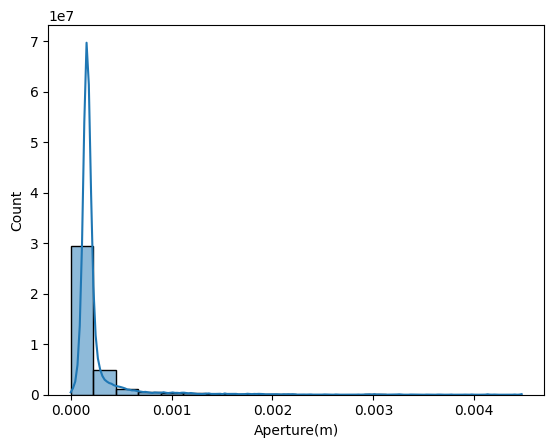

In [43]:
# Plot histogram with seaborn
sns.histplot(data=pd.DataFrame(np.ravel(aperture),columns=["Aperture(m)"]),x="Aperture(m)",bins=20,kde=True)

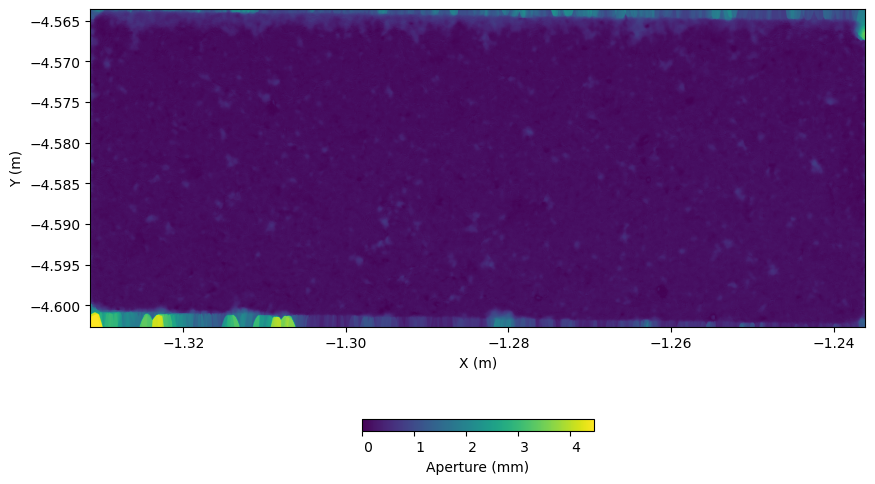

In [44]:
# Plot aperture
plot_aperture_heatmap(X, Y, aperture, zmax=np.max(aperture*1000))

## Check metrics

In [47]:
print("min x: %f\t max x: %f\n" % (xmin,xmax))

min x: -1.331420	 max x: -1.236090



In [48]:
print("min y: %f\t max y: %f\n" % (ymin,ymax))

min y: -4.602650	 max y: -4.563580



In [50]:
print("Size\t Lenght: %f\t Width: %f\n" % (xmax-xmin,ymax-ymin))

Size	 Lenght: 0.095330	 Width: 0.039070



In [55]:
print("Distance between points\t x_A: %.1e\t x_B: %.1e\t y_A: %.1e\t y_B: %.1e\n" % (xup_dist,xlow_dist,yup_dist,ylow_dist))

Distance between points	 x_A: 1.0e-05	 x_B: 1.0e-05	 y_A: 1.0e-05	 y_B: 1.0e-05



In [52]:
print("number of points in x: %d\t y:%d\n" % (round(x_steps),round(y_steps)))

number of points in x: 9533	 y:3907



## Domain of interest

Looks like the x axis of this core sample is not aligned.

Let's crop the fractured region in a rectangular shape.

In [ ]:
# Load generated file
ilb_df = pd.read_csv('aperture_Indiana_' + sample + '.txt', sep=',',header=None,names=['x','y','z'])

In [ ]:
# Filter dataset with conditions
ilb_selection = ilb_df[(ilb_df['y']>-4.6)&(ilb_df['y']<-4.565)]

In [ ]:
ilb_selection.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33365500 entries, 2526245 to 35891744
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       float64
 1   y       float64
 2   z       float64
dtypes: float64(3)
memory usage: 1018.2 MB


In [ ]:
# Check size after selection
ilb_selection.shape

(33365500, 3)

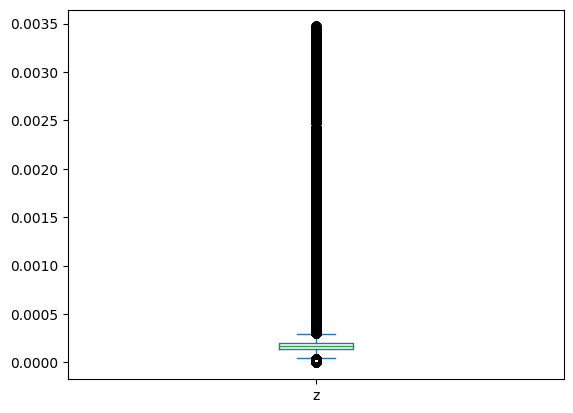

In [ ]:
# Check distribution of dataset after selection
ax2 = ilb_selection.plot.box(column='z')

In [ ]:
# Another selection based on same criterion
# axis limits
ymin_sel = -4.600
ymax_sel = -4.565
xmax_sel = -1.238

# Create spaced numbers over a new interval
x2 = np.linspace(xmin, xmax_sel, x_steps)
y2 = np.linspace(ymin_sel, ymax_sel, y_steps)

# Mesh
X2,Y2 = np.meshgrid(x2,y2)

In [ ]:
# Get z for each (x,y) pair for each surface
Zup_sel = calculate_z(xup,yup,zup, X2, Y2)
Zdown_sel = calculate_z(xlow,ylow,zlow, X2, Y2)

In [ ]:
# Get cropped fracture aperture
aperture_sel = calculate_distance(Zup_sel, Zdown_sel)

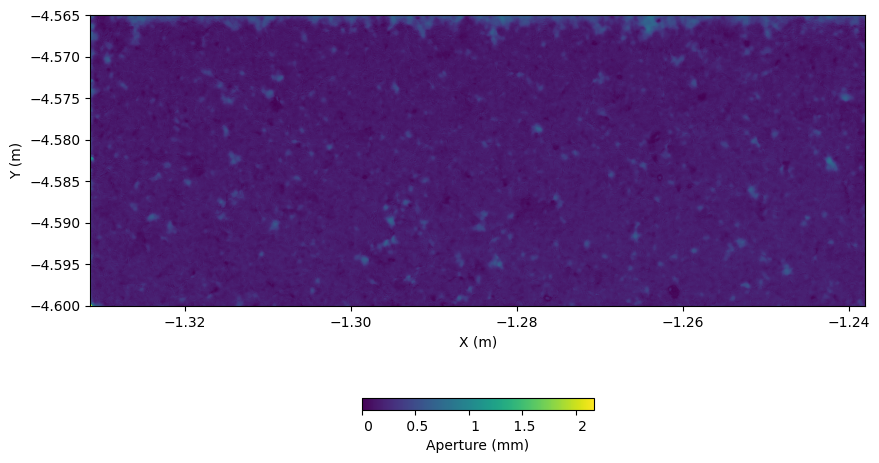

In [ ]:
# Plot aperture with colorbar limits based on maximum aperture
plot_aperture_heatmap(X2, Y2, aperture_sel, zmax=np.max(aperture_sel*1000))

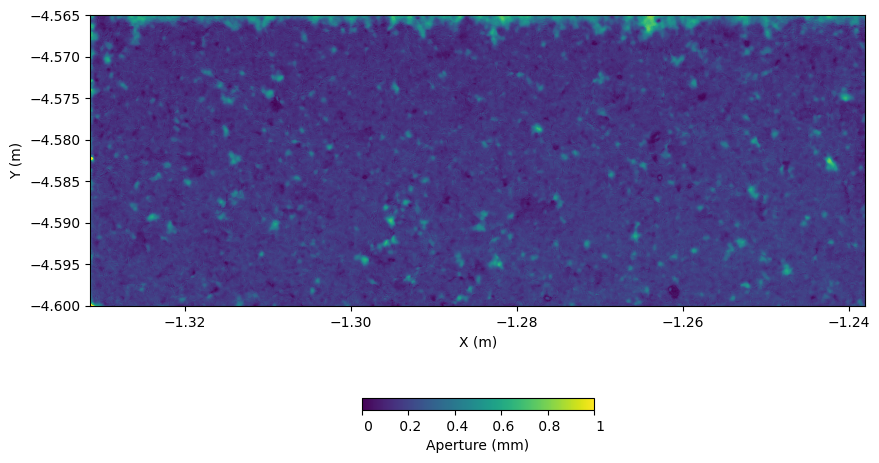

In [ ]:
# Plot cropped fracture
plot_aperture_heatmap(X2, Y2, aperture_sel)